In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import threading
import obspy
from obspy.clients.seedlink.easyseedlink import create_client, EasySeedLinkClient

## realtime station information
http://ds.iris.edu/gmap/#network=_REALTIME&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

http://ds.iris.edu/gmap/#network=_REALTIME&channel=HH*&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

In [36]:
NETWORK = "UW"
MIN_LAT = 46.6
MAX_LAT = 48.6
MIN_LON = -123.6
MAX_LON = -121.6
CENTER = ((MIN_LON + MAX_LON)/2.0, (MIN_LAT + MAX_LAT)/2.0)
PI = 3.1415926
DEGREE2KM = PI*6371/180
CHANNELS = "HHE,HHN,HHZ"

In [27]:
stations = pd.read_csv("realtime-stations.txt", sep="|",  header=None, skiprows=3, names=["network", "station", "latitude", "longitude", "elevation(m)", "location", "starttime", "endtime"])
stations = stations[stations["network"] == NETWORK]

(-124.93312499999999, -116.860775, 42.419448000000003, 49.159191999999997)

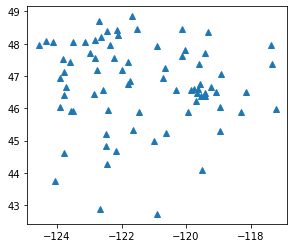

In [28]:
plt.figure()
plt.plot(stations["longitude"], stations["latitude"], '^')
plt.axis("scaled")

16


(-123.59255105, -121.64442794999999, 46.66693695, 48.507502050000006)

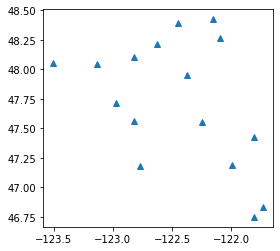

In [29]:
# stations = stations[(46.5 < stations["latitude"]) & (stations["latitude"] < 49)]
# stations = stations[(-125 < stations["longitude"]) & (stations["longitude"] < -123.5)]

stations = stations[(MIN_LAT < stations["latitude"]) & (stations["latitude"] < MAX_LAT)]
stations = stations[(MIN_LON < stations["longitude"]) & (stations["longitude"] < MAX_LON)]

stations["station_id"] = stations["network"] + "." + stations["station"]
stations = stations.reset_index()
print(len(stations))
plt.figure()
plt.plot(stations["longitude"], stations["latitude"], '^')
plt.axis("scaled")

Number of stations: 19


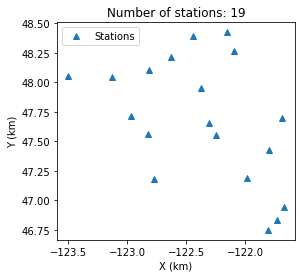

In [38]:
import pickle, os
import obspy
from obspy.clients.fdsn import Client
from collections import defaultdict
import pandas as pd


####### Download stations ########
stations = Client("IRIS").get_stations(network = NETWORK,
                                       station = "*",
                                       starttime=obspy.UTCDateTime("2021-04-03"),
                                       minlongitude=MIN_LON,
                                       maxlongitude=MAX_LON,
                                       minlatitude=MIN_LAT,
                                       maxlatitude=MAX_LAT,
                                       channel=CHANNELS,
                                       level="response")#,
#                                            filename="stations.xml")

#     stations = obspy.read_inventory("stations.xml")
print("Number of stations: {}".format(sum([len(x) for x in stations])))
# stations.plot('local', outfile="stations.png")
# stations.plot('local')

####### Save stations ########
station_locs = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            x = (chn.longitude - CENTER[0])*DEGREE2KM
            y = (chn.latitude - CENTER[1])*DEGREE2KM
            z = -chn.elevation / 1e3 #km
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["x(km)"], tmp_dict["y(km)"], tmp_dict["z(km)"] = x, y, z
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = chn.longitude, chn.latitude, chn.elevation
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs.to_csv("stations_iris.csv",
                    sep="\t", float_format="%.3f",
                    index_label="station",
                    columns=["x(km)", "y(km)", "z(km)", "latitude", "longitude", "elevation(m)", "unit", "component", "response"])
#                     columns=["longitude", "latitude", "elevation(m)", "unit", "component", "response"])


#     ####### Plot stations ########
plt.figure()
plt.plot(station_locs["longitude"], station_locs["latitude"], "^", label="Stations")
#     plt.plot(catalog["x(km)"], catalog["y(km)"], "k.", label="Earthquakes")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("scaled")
plt.legend()
plt.title(f"Number of stations: {len(station_locs)}")
#     plt.savefig(os.path.join(data_path, "stations_loc.png"))
plt.show()

In [6]:
class Client(EasySeedLinkClient):
    def on_data(self, trace):
        print('Received trace:', trace.id)
        print(trace)
        value = {"timestamp":trace.stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3], "vec":trace.data.tolist()}
            
client = Client('rtserve.iris.washington.edu:18000')
for index, row in stations.iterrows():
    client.select_stream(row["network"], row["station"], "HH?")
client.run()

Received trace: UW.DONK..HHE
UW.DONK..HHE | 2021-04-03T23:41:16.860000Z - 2021-04-03T23:41:23.820000Z | 100.0 Hz, 697 samples
Received trace: UW.DONK..HHZ
UW.DONK..HHZ | 2021-04-03T23:41:17.160000Z - 2021-04-03T23:41:24.090000Z | 100.0 Hz, 694 samples
Received trace: UW.DOSE..HHN
UW.DOSE..HHN | 2021-04-03T23:41:19.020000Z - 2021-04-03T23:41:23.080000Z | 100.0 Hz, 407 samples
Received trace: UW.LRIV..HHE
UW.LRIV..HHE | 2021-04-03T23:41:19.740000Z - 2021-04-03T23:41:24.390000Z | 100.0 Hz, 466 samples
Received trace: UW.NATEM..HHZ
UW.NATEM..HHZ | 2021-04-03T23:41:17.590000Z - 2021-04-03T23:41:21.680000Z | 100.0 Hz, 410 samples
Received trace: UW.SALO..HHN
UW.SALO..HHN | 2021-04-03T23:41:18.310000Z - 2021-04-03T23:41:24.220000Z | 100.0 Hz, 592 samples
Received trace: UW.SP2..HHZ
UW.SP2..HHZ | 2021-04-03T23:41:19.740000Z - 2021-04-03T23:41:24.100000Z | 100.0 Hz, 437 samples
Received trace: UW.BERY..HHE
UW.BERY..HHE | 2021-04-03T23:41:19.730000Z - 2021-04-03T23:41:24.810000Z | 100.0 Hz, 509 

KeyboardInterrupt: 